In [2]:
import cv2
import numpy as np
import tensorflow as tf
import keras
import glob
import albumentations as A
import matplotlib.pyplot as plt
import time

# Dataset Loading


In [3]:
tf.config.run_functions_eagerly(True) 

In [4]:
image_filename =  '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_images/*.jpg'
masks_filename = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_masks/*.jpg'

In [5]:
img_filename_list = []
for files in sorted(glob.glob(image_filename)):
    img_filename_list.append(files)
    
mask_filename_list = []
for files in sorted(glob.glob(masks_filename)):
    mask_filename_list.append(files)

In [6]:
print(len(img_filename_list))
print(len(mask_filename_list))

2683
2683


In [7]:
train_img_filename_list = img_filename_list[:1000]
train_mask_filename_list = mask_filename_list[:1000]

In [8]:
test_img_filename_list = img_filename_list[1500:2000]
test_mask_filename_list = mask_filename_list[1500:2000]

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((train_img_filename_list, train_mask_filename_list))

In [10]:
def decode_images(img_filename, mask_filename):
    image_string = tf.io.read_file(img_filename)
    mask_string = tf.io.read_file(mask_filename)
    
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    mask = tf.image.decode_jpeg(mask_string, channels=1)
    
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    image = tf.image.resize(image, (256, 256))
    mask = tf.image.resize(mask, (256, 256))
    
    return image, mask

In [11]:
dataset = dataset.map(decode_images)
dataset = dataset.batch(16)
dataset = dataset.prefetch(1)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [12]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [13]:
im, m = next(iter(dataset))

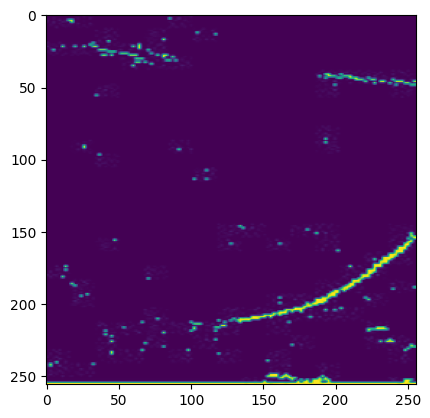

In [14]:
plt.imshow(m[5])

# Data Augmentation

2025-02-20 19:19:49.388901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 19:19:49.389053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 19:19:49.537366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Total images: 2683
Total masks: 2683


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Image batch shape: (16, 128, 128, 3)
Mask batch shape: (16, 128, 128, 1)


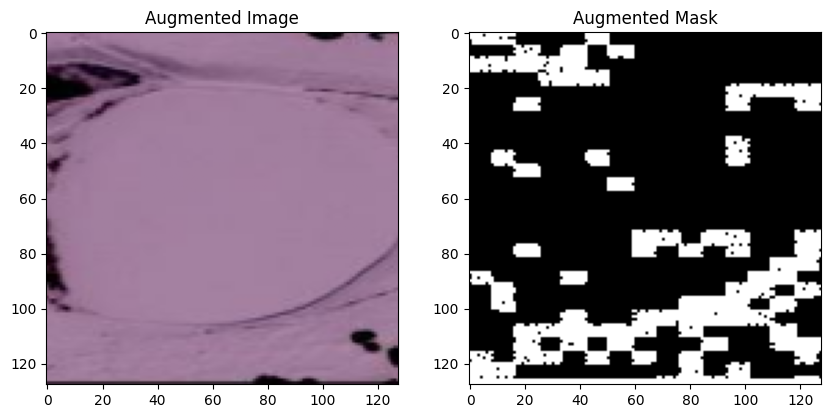

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import keras
import glob
import albumentations as A
import matplotlib.pyplot as plt
import time

tf.config.run_functions_eagerly(True)

# File paths
image_filename = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_images/*.jpg'
masks_filename = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_masks/*.jpg'

# Reading file names
img_filename_list = sorted(glob.glob(image_filename))
mask_filename_list = sorted(glob.glob(masks_filename))

print(f"Total images: {len(img_filename_list)}")
print(f"Total masks: {len(mask_filename_list)}")

# Splitting into train and test sets
train_img_filename_list = img_filename_list[:1000]
train_mask_filename_list = mask_filename_list[:1000]
test_img_filename_list = img_filename_list[1500:2000]
test_mask_filename_list = mask_filename_list[1500:2000]

import tensorflow as tf
import albumentations as A
import numpy as np

@tf.function
def augment(image, mask):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Resize(256, 256)
    ])
    
    # Convert TensorFlow tensors to NumPy arrays
    image = image.numpy() if isinstance(image, tf.Tensor) else image
    mask = mask.numpy() if isinstance(mask, tf.Tensor) else mask
    
    augmented = transform(image=image, mask=mask)
    
    # Return the augmented image and mask as tensors
    return tf.convert_to_tensor(augmented['image'], dtype=tf.float32), tf.convert_to_tensor(augmented['mask'], dtype=tf.float32)

import tensorflow as tf
import glob

# Define paths to image and mask directories
image_dir = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_images/*.jpg'
mask_dir = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_masks/*.jpg'

# Get list of image and mask filenames
train_img_filename_list = sorted(glob.glob(image_dir))
train_mask_filename_list = sorted(glob.glob(mask_dir))

# Define the decode_images function
def decode_images(image_filename, mask_filename):
    image = tf.io.read_file(image_filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0  # Normalize to [0, 1]

    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [128, 128])
    mask = tf.cast(mask > 0, tf.float32)  # Binarize mask

    return image, mask

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_filename_list, train_mask_filename_list))

# Apply the map function to decode images and masks
train_dataset = train_dataset.map(lambda img, mask: decode_images(img, mask), num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the dataset for performance
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

# Verify the dataset
for image_batch, mask_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Mask batch shape:", mask_batch.shape)



# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_filename_list, train_mask_filename_list))
train_dataset = train_dataset.map(decode_images)
train_dataset = train_dataset.batch(16)
train_dataset = train_dataset.prefetch(1)

# Visualize a sample
im, m = next(iter(train_dataset))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im[5])
plt.title('Augmented Image')
plt.subplot(1, 2, 2)
plt.imshow(m[5].numpy().squeeze(), cmap='gray')
plt.title('Augmented Mask')
plt.show()


# trail

# DeepLabV3

Total images: 2683
Total masks: 2683
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,830,209 (68.02 MB)

 Trainable params: 17,795,425 (67.88 MB)

 Non-trainable params: 34,784 (135.88 KB)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.7289 - loss: 0.4141 - val_accuracy: 0.2965 - val_loss: 0.5450 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8368 - loss: 0.2814 - val_accuracy: 0.2965 - val_loss: 0.5450 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8594 - loss: 0.2517 - val_accuracy: 0.2965 - val_loss: 0.5450 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8739 - loss: 0.2273 - val_accuracy: 0.2965 - val_loss: 0.5450 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8860 - loss: 0.2085 - val_accuracy: 0.2965 - val_loss: 0.5450 - learning_rate: 1.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8975 - loss: 0.1911
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
75/75 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8976 - loss:

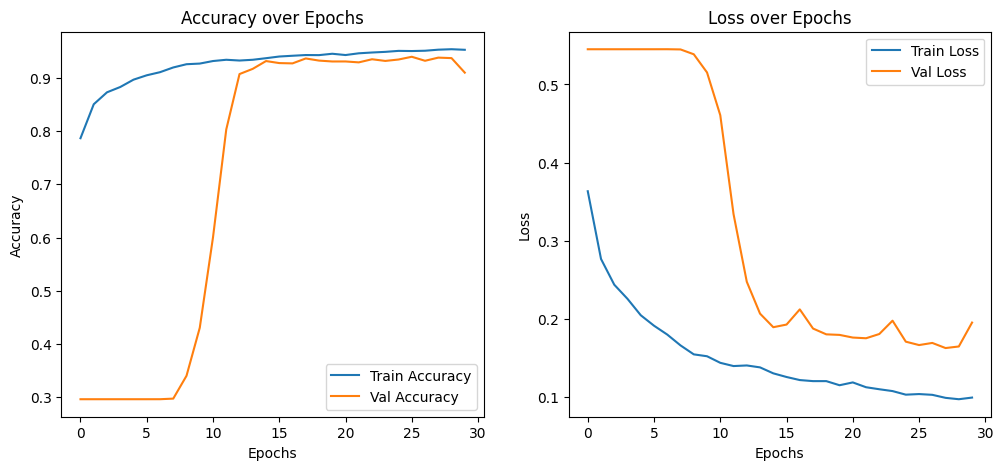

In [2]:
import glob
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# =============================
# File Paths & Dataset Splitting
# =============================

# Change these paths to point to your dataset images and masks
image_pattern = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_images/*.jpg'
mask_pattern = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_masks/*.jpg'

img_files = sorted(glob.glob(image_pattern))
mask_files = sorted(glob.glob(mask_pattern))

print(f"Total images: {len(img_files)}")
print(f"Total masks: {len(mask_files)}")

# Split into training and validation sets (adjust indices as needed)
train_img_files = img_files[:1200]
train_mask_files = mask_files[:1200]
val_img_files = img_files[1200:1400]
val_mask_files = mask_files[1200:1400]

# =============================
# Data Augmentation using Albumentations
# =============================

def augment(image, mask):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ElasticTransform(p=0.2),
        A.Resize(256, 256)  # Ensure images are 256x256
    ])
    augmented = transform(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# =============================
# Preprocessing Function for tf.data Pipeline
# =============================

def load_and_preprocess(image_path, mask_path, augment_data=False):
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    
    # Read and decode the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    
    # Cast to uint8 for augmentation compatibility
    image = tf.cast(image, tf.uint8)
    mask = tf.cast(mask, tf.uint8)
    
    if augment_data:
        image, mask = tf.py_function(func=lambda img, msk: augment(img.numpy(), msk.numpy()),
                                     inp=[image, mask],
                                     Tout=[tf.uint8, tf.uint8])
        image.set_shape([256, 256, 3])
        mask.set_shape([256, 256, 1])
    
    # Convert image to float32 and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Normalize mask to binary values (assumes mask pixel values are 0-255)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0)
    
    return image, mask

BATCH_SIZE = 16

train_dataset = tf.data.Dataset.from_tensor_slices((train_img_files, train_mask_files))
train_dataset = train_dataset.map(lambda img, msk: load_and_preprocess(img, msk, augment_data=True),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_img_files, val_mask_files))
val_dataset = val_dataset.map(lambda img, msk: load_and_preprocess(img, msk, augment_data=False),
                              num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =============================
# DeepLabV3+ Model Definition
# =============================

def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Backbone: ResNet50 pre-trained on ImageNet
    base_model = tf.keras.applications.ResNet50(input_tensor=inputs,
                                                weights='imagenet',
                                                include_top=False)
    
    # Low-level feature from an early layer (for finer details)
    x_low = base_model.get_layer("conv2_block3_out").output  # e.g. shape: 64x64x256
    
    # High-level features from a deeper layer
    x = base_model.get_layer("conv4_block6_out").output  # e.g. shape: 16x16x1024
    
    # ----------------------------
    # Atrous Spatial Pyramid Pooling (ASPP)
    # ----------------------------
    # Branch 1: 1x1 convolution
    b0 = tf.keras.layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    b0 = tf.keras.layers.BatchNormalization()(b0)
    b0 = tf.keras.layers.Activation("relu")(b0)
    
    # Branch 2: 3x3 convolution with dilation rate 6
    b1 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", dilation_rate=6, use_bias=False)(x)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)
    
    # Branch 3: 3x3 convolution with dilation rate 12
    b2 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", dilation_rate=12, use_bias=False)(x)
    b2 = tf.keras.layers.BatchNormalization()(b2)
    b2 = tf.keras.layers.Activation("relu")(b2)
    
    # Branch 4: 3x3 convolution with dilation rate 18
    b3 = tf.keras.layers.Conv2D(256, (3, 3), padding="same", dilation_rate=18, use_bias=False)(x)
    b3 = tf.keras.layers.BatchNormalization()(b3)
    b3 = tf.keras.layers.Activation("relu")(b3)
    
    # Image-level features
    b4 = tf.keras.layers.GlobalAveragePooling2D()(x)
    b4 = tf.keras.layers.Reshape((1, 1, tf.keras.backend.int_shape(x)[-1]))(b4)
    b4 = tf.keras.layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(b4)
    b4 = tf.keras.layers.BatchNormalization()(b4)
    b4 = tf.keras.layers.Activation("relu")(b4)
    # Upsample to match the spatial dimensions of x (e.g., 16x16)
    b4 = tf.keras.layers.UpSampling2D(size=(tf.keras.backend.int_shape(x)[1],
                                              tf.keras.backend.int_shape(x)[2]),
                                      interpolation="bilinear")(b4)
    
    # Concatenate all ASPP branches
    x_aspp = tf.keras.layers.Concatenate()([b4, b0, b1, b2, b3])
    x_aspp = tf.keras.layers.Conv2D(256, (1, 1), padding="same", use_bias=False)(x_aspp)
    x_aspp = tf.keras.layers.BatchNormalization()(x_aspp)
    x_aspp = tf.keras.layers.Activation("relu")(x_aspp)
    
    # ----------------------------
    # Decoder
    # ----------------------------
    # Process low-level features
    x_low = tf.keras.layers.Conv2D(48, (1, 1), padding="same", use_bias=False)(x_low)
    x_low = tf.keras.layers.BatchNormalization()(x_low)
    x_low = tf.keras.layers.Activation("relu")(x_low)
    
    # Upsample ASPP output to match low-level spatial resolution
    x_aspp_up = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x_aspp)
    
    # Concatenate low-level features and upsampled ASPP output
    x = tf.keras.layers.Concatenate()([x_aspp_up, x_low])
    
    # Further refine the features
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    
    # Upsample to the original image size (256x256)
    x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    
    # Final segmentation head
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1)
model.summary()

# =============================
# Loss Functions: Dice Loss + Binary Focal Loss
# =============================

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) /
                (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth))

def binary_focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true + (1 - alpha) * (1 - y_true)
        loss = weight * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Combined loss: Dice loss + Focal loss
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + binary_focal_loss()(y_true, y_pred)

# =============================
# Compile the Model
# =============================

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=['accuracy'])

# =============================
# Train the Model
# =============================

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=30,
                    callbacks=callbacks,
                    verbose=1)

# Save the model
model.save('/kaggle/working/deeplabv3plus_model.h5')

# =============================
# Evaluate the Model
# =============================

loss, accuracy = model.evaluate(val_dataset, verbose=1)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# =============================
# Plot Training History
# =============================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.show()

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# Function to generate predictions and compute metrics
def evaluate_model(model, dataset):
    y_true_list = []
    y_pred_list = []
    
    for image_batch, mask_batch in dataset:
        # Get model predictions
        y_pred = model.predict(image_batch)
        
        # Threshold predictions to obtain binary masks
        y_pred = (y_pred > 0.5).astype(np.uint8)
        
        # Flatten both predictions and ground truth masks
        y_true_list.append(mask_batch.numpy().flatten())
        y_pred_list.append(y_pred.flatten())
    
    # Convert lists to arrays
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute Evaluation Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred)  # IoU (Jaccard Index)
    dice_coeff = (2 * precision * recall) / (precision + recall + 1e-7)  # Dice Score

    return cm, accuracy, precision, recall, f1, iou, dice_coeff

# Compute metrics for the validation dataset
cm, accuracy, precision, recall, f1, iou, dice_coeff = evaluate_model(model, val_dataset)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU (Jaccard Index): {iou:.4f}")
print(f"Dice Coefficient: {dice_coeff:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Accuracy: 0.9615
Precision: 0.9640
Recall: 0.9973
F1 Score: 0.9804
IoU (Jaccard Index): 0.9615
Dice Coefficient: 0.9804


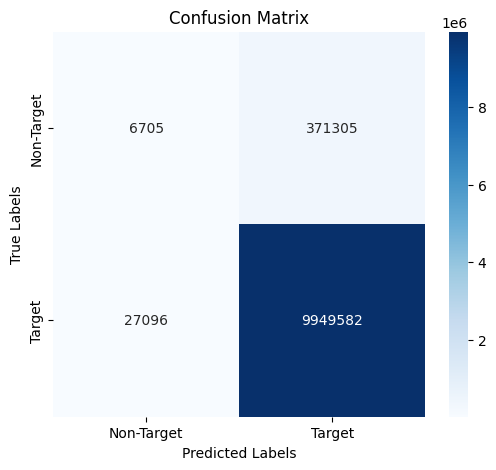

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_labels=["Non-Target", "Target"]):
    """
    Function to plot a confusion matrix.
    
    Parameters:
    - cm: Computed confusion matrix (2x2 array).
    - class_labels: Class labels for the heatmap.
    """
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    # Labels and title
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function with the computed confusion matrix
plot_confusion_matrix(conf_matrix)


# Unet Model

Total images: 2683
Total masks: 2683


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │    131,200 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │    295,040 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_18[0][0] 

 Total params: 1,865,409 (7.12 MB)

 Trainable params: 1,864,129 (7.11 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.6284 - loss: 0.3769 - val_accuracy: 0.6666 - val_loss: 0.5050 - learning_rate: 1.0000e-04
Epoch 2/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - accuracy: 0.6847 - loss: 0.3015 - val_accuracy: 0.6781 - val_loss: 0.5649 - learning_rate: 1.0000e-04
Epoch 3/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 497ms/step - accuracy: 0.6979 - loss: 0.2953 - val_accuracy: 0.6832 - val_loss: 0.5683 - learning_rate: 1.0000e-04
Epoch 4/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 499ms/step - accuracy: 0.6954 - loss: 0.2936 - val_accuracy: 0.7387 - val_loss: 0.3543 - learning_rate: 1.0000e-04
Epoch 5/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 497ms/step - accuracy: 0.7060 - loss: 0.2900 - val_accuracy: 0.6975 - val_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 6/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 497ms/step - accuracy: 0.7127 - loss: 0.2853 - val_accuracy: 0.7218 - val_loss: 0.3061 - learning_rate: 1.0000e-04
Epoch 7/60
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 498ms/step - acc

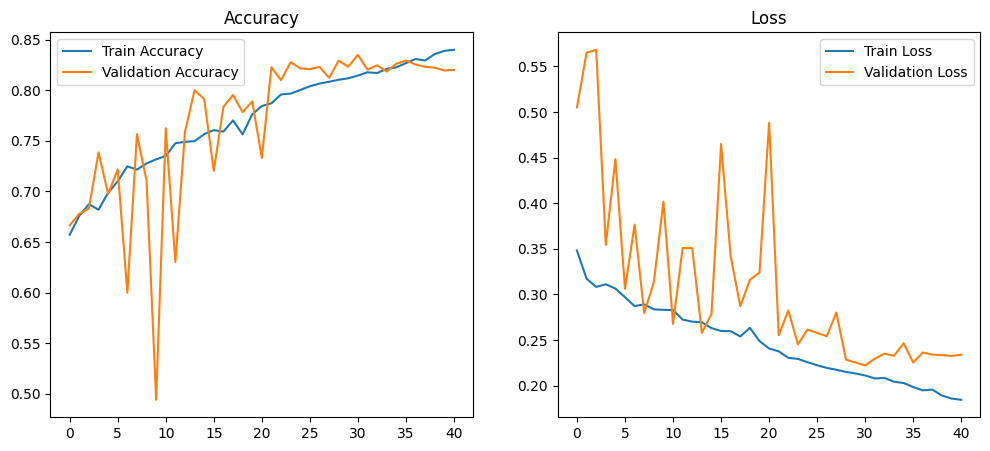

In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import albumentations as A
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# ============================
# Data Preprocessing & Augmentation
# ============================

# File paths
image_filename = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_images/*.jpg'
mask_filename = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_masks/*.jpg'

# Reading file names
img_filename_list = sorted(glob.glob(image_filename))
mask_filename_list = sorted(glob.glob(mask_filename))  # Fixed the variable name

print(f"Total images: {len(img_filename_list)}")
print(f"Total masks: {len(mask_filename_list)}")

# Splitting into train and test sets
train_img_filename_list = img_filename_list[:1200]  # Training data
train_mask_filename_list = mask_filename_list[:1200]
val_img_filename_list = img_filename_list[1200:1400]  # Validation data
val_mask_filename_list = mask_filename_list[1200:1400]

# Data augmentation function
def augment(image, mask):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ElasticTransform(p=0.2),
        A.Resize(256, 256)  # Resize to 256x256
    ])
    
    augmented = transform(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Function to load and process images
def decode_images(image_filename, mask_filename):
    image = tf.io.read_file(image_filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize
    
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = tf.cast(mask > 0, tf.float32)  # Convert mask to binary format

    return image, mask

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_filename_list, train_mask_filename_list))
train_dataset = train_dataset.map(lambda img, mask: decode_images(img, mask), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_img_filename_list, val_mask_filename_list))
val_dataset = val_dataset.map(lambda img, mask: decode_images(img, mask), num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

# ============================
# Improved U-Net Model
# ============================

def build_unet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder (Feature extraction)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)

    # Decoder (Upsampling with skip connections)
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# ============================
# Custom Loss Function (Dice Loss)
# ============================

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth))

# Compile the model
model = build_unet()
model.compile(optimizer=optimizers.AdamW(learning_rate=1e-4),
              loss=dice_loss,
              metrics=['accuracy'])

# Display model summary
model.summary()

# ============================
# Train the Model
# ============================

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=60,
                    callbacks=callbacks,
                    verbose=1)

# Save the improved model
model.save('/kaggle/working/flood_detection_model_v2.h5')

# ============================
# Evaluate the Model
# ============================

loss, accuracy = model.evaluate(val_dataset, verbose=1)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# ============================
# Plot Training History
# ============================

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.show()


In [25]:
def calculate_iou_per_image(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))
    return intersection / union

# Loop through each image in the validation dataset
iou_per_image = []

for true_mask, pred_mask in zip(val_masks_binary, y_pred_binary):
    iou = calculate_iou_per_image(true_mask.flatten(), pred_mask.flatten())
    iou_per_image.append(iou)

# Calculate the average IoU over all images
average_iou = np.mean(iou_per_image)
print(f"Average IoU: {average_iou:.4f}")


Average IoU: 0.5965


# Attention Unet

In [51]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [ ]:
input_shape = (256, 256, 3)
attention_unet = build_attention_unet(input_shape)
attention_unet.summary()

# Compile the model
attention_unet.compile(optimizer='adam', 
                       loss=tf.keras.losses.BinaryCrossentropy(), 
                       metrics=['accuracy'])

In [55]:
import tensorflow as tf  
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Add, Multiply  
import time  
from tensorflow.keras import mixed_precision  

# Set mixed precision policy if supported  
policy = mixed_precision.Policy('mixed_float16')  
mixed_precision.set_global_policy(policy)  

# Attention Block  
def attention_block(x, g, inter_channels):  
    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)  
    phi_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)  
    add_xg = Add()([theta_x, phi_g])  
    relu_xg = Activation('relu')(add_xg)  
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(relu_xg)  
    psi = Activation('sigmoid')(psi)  
    attn_output = Multiply()([x, psi])  
    return attn_output  

# Convolutional Block  
def conv_block(input, num_filters):  
    x = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(input)  
    x = BatchNormalization()(x)  
    x = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(x)  
    x = BatchNormalization()(x)  
    return x  

# Encoder Block  
def encoder_block(input, num_filters):  
    x = conv_block(input, num_filters)  
    p = MaxPooling2D((2, 2))(x)  
    return x, p  

# Decoder Block with Attention  
def decoder_block(input, skip_features, num_filters):  
    x = Conv2DTranspose(num_filters, kernel_size=2, strides=2, padding='same')(input)  
    attn_skip = attention_block(skip_features, x, num_filters // 2)  
    x = concatenate([x, attn_skip])  
    x = conv_block(x, num_filters)  
    return x  

# Build Attention U-Net  
def build_attention_unet(input_shape):  
    inputs = Input(input_shape)  

    # Encoder  
    s1, p1 = encoder_block(inputs, 32)  # Reduced number of filters  
    s2, p2 = encoder_block(p1, 64)  
    s3, p3 = encoder_block(p2, 128)  
    s4, p4 = encoder_block(p3, 256)  

    # Bridge  
    b1 = conv_block(p4, 512)  # Reduced number of filters  

    # Decoder  
    d1 = decoder_block(b1, s4, 256)  
    d2 = decoder_block(d1, s3, 128)  
    d3 = decoder_block(d2, s2, 64)  
    d4 = decoder_block(d3, s1, 32)  

    # Output  
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(d4)  

    model = Model(inputs, outputs, name="Attention-U-Net")  
    return model  

# Build model with input size (256, 256, 3)  
attention_unet = build_attention_unet(input_shape=(256, 256, 3))  

# Compile the model  
attention_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  

# Train Attention U-Net with dataset and reduced batch size  
with tf.device("/device:GPU:0"):  
    starting_time = time.time()  
    
    # Replace 'dataset' with your actual dataset and 'validation_data' if applicable  
    attention_history = attention_unet.fit(  
        dataset,  # Replace with your actual dataset  
        batch_size=8,  # Further reduced batch size to fit in memory  
        epochs=20,  
        verbose=1  
    )  
    
    print('Attention U-Net training time:', time.time() - starting_time)  

# Get final accuracy  
final_accuracy = attention_history.history['accuracy'][-1]  
print(f'Final training accuracy: {final_accuracy * 100:.2f}%')  

# If validation data was used, print final validation accuracy  
if 'val_accuracy' in attention_history.history:  
    final_val_accuracy = attention_history.history['val_accuracy'][-1]  
    print(f'Final validation accuracy: {final_val_accuracy * 100:.2f}%')

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 966ms/step - accuracy: 0.5698 - loss: 0.6265
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 843ms/step - accuracy: 0.6418 - loss: 0.4852
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - accuracy: 0.6399 - loss: 0.4885
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 849ms/step - accuracy: 0.6411 - loss: 0.4779
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 849ms/step - accuracy: 0.6473 - loss: 0.4705
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 849ms/step - accuracy: 0.6551 - loss: 0.4637
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 847ms/step - accuracy: 0.6614 - loss: 0.4404
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 849ms/step - accuracy: 0.6632 - loss: 0.4371
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 858ms/step - accuracy: 0.6637 - loss: 0.4341
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - accuracy: 0.6680 - loss: 0.4220
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 849ms/step - accuracy: 0.6725 - loss: 0.4133
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 54

In [56]:
# Get final accuracy  
final_accuracy = attention_history.history['accuracy'][-1]  
print(f'Final training accuracy: {final_accuracy * 100:.2f}%')  

# If validation data was used, print final validation accuracy  
if 'val_accuracy' in attention_history.history:  
    final_val_accuracy = attention_history.history['val_accuracy'][-1]  
    print(f'Final validation accuracy: {final_val_accuracy * 100:.2f}%')  

# Define the path to the Desktop (for Windows)  
downloads_path = os.path.expanduser(r"C:\Users\pulat\OneDrive\Desktop")  # for Windows  

# Create a folder to save

Final training accuracy: 70.92%


In [43]:
import tensorflow as tf


In [45]:
attention_unet.compile(
    optimizer='adam', 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy']
)


In [ ]:
print(tf.__version__)


In [ ]:
import time

# Residual Unet

In [22]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Residual Block
def residual_block(input, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    res = layers.Conv2D(num_filters, (1, 1), padding='same')(input)  # Matching dimensions for the residual connection
    x = layers.Add()([x, res])  # Add the residual connection
    return x

def resunet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder with residual blocks
    c1 = residual_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck (No residual block here)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder with residual blocks
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = residual_block(u1, 128)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = residual_block(u2, 64)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Helper function to load images and masks
def load_data(image_dir, mask_dir, image_size=(128, 128)):
    images = []
    masks = []

    # List image and mask file names (assuming both dirs have corresponding filenames)
    image_files = os.listdir(image_dir)
    mask_files = os.listdir(mask_dir)

    for image_file, mask_file in zip(image_files, mask_files):
        # Load and preprocess image
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load images and masks
        image = load_img(image_path, target_size=image_size)
        mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")

        # Convert images to numpy arrays
        image = img_to_array(image) / 255.0  # Normalize images to [0, 1]
        mask = img_to_array(mask) / 255.0  # Normalize masks to [0, 1]

        images.append(image)
        masks.append(mask)

    # Convert lists to numpy arrays
    return tf.convert_to_tensor(images), tf.convert_to_tensor(masks)

# Load the dataset (replace with your actual paths)
image_dir = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_images'
mask_dir = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/train_masks'

# Load data
images, masks = load_data(image_dir, mask_dir)

# Split data into training and validation sets
split = int(0.8 * len(images))  # 80% train, 20% validation
train_images, val_images = images[:split], images[split:]
train_masks, val_masks = masks[:split], masks[split:]

# Build the model
model = resunet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

# Train the model
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=20,
    batch_size=8,
    verbose=1
)

# Save the model after training
model.save('resunet_model.h5')

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_images, val_masks, verbose=1)

# Print validation accuracy
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")




Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_73[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 128, 128,  │        256 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 128, 128,  │          0 │ conv2d_74[0][0],  │
│                     │ 64)               │            │ conv2d_75[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ add_21[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_76[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 64, 64,    │      8,320 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 64, 64,    │          0 │ conv2d_77[0][0],  │
│                     │ 128)              │            │ conv2d_78[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ add_22[0][0]      │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_79[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 64, 64,    │    131,200 │ conv2d_80[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ add_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 64, 64,    │    295,040 │ concatenate_10[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_81[0][0] 

 Total params: 1,912,577 (7.30 MB)

 Trainable params: 1,912,577 (7.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.5302 - loss: 159230160.0000 - val_accuracy: 0.4364 - val_loss: 38284791808.0000
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5211 - loss: 27381516288.0000 - val_accuracy: 0.6190 - val_loss: 226935881728.0000
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5012 - loss: 26092276547584.0000 - val_accuracy: 0.6059 - val_loss: 1007297606189056.0000
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5212 - loss: 405818004471808.0000 - val_accuracy: 0.5799 - val_loss: 28592597630976.0000
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5217 - loss: 51201148190720.0000 - val_accuracy: 0.5687 - val_loss: 21376415039488.0000
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5304 - loss: 34211780100096.0000 - val_accuracy: 0.6062 - val_loss: 31751520911360.0000
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.5137 -

# Evaluation Metrics

In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Define the Custom Data Generator class
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_dir, masks_dir, batch_size, img_size, shuffle=True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.indexes = np.arange(len(self.image_filenames))

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Get indices for this batch
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        masks = []
        
        for i in batch_indices:
            img_path = os.path.join(self.images_dir, self.image_filenames[i])
            mask_path = os.path.join(self.masks_dir, self.mask_filenames[i])
            
            # Load image and mask
            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming mask is single channel
            
            # Resize image and mask to the target size
            image = cv2.resize(image, self.img_size)
            mask = cv2.resize(mask, self.img_size)
            
            # Normalize image and convert mask to binary (0 or 1)
            image = image / 255.0
            mask = np.expand_dims(mask, axis=-1)  # For binary segmentation, make mask single-channel
            
            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Define the metric calculation function
def calculate_metrics_from_model(model, dataloader, num_classes):
    all_preds = []
    all_labels = []

    for images, labels in dataloader:
        # Ensure labels are in class indices form for confusion matrix calculation
        labels = np.squeeze(labels)  # Convert mask to 2D array if it's (batch, height, width, 1)

        outputs = model(images)
        preds = np.argmax(outputs, axis=-1)  # Get predicted class indices

        all_preds.append(preds)
        all_labels.append(labels)

    # Flatten the predictions and labels
    all_preds = np.concatenate(all_preds).flatten()  # Flatten to 1D arrays
    all_labels = np.concatenate(all_labels).flatten()

    # Check if all_preds and all_labels are the correct shape and values
    print(f"all_preds shape: {all_preds.shape}, all_labels shape: {all_labels.shape}")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

    # Calculate metrics
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP

    # Overall accuracy
    accuracy = np.sum(TP) / np.sum(conf_matrix)

    # Precision, Recall, IoU per class
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    iou = TP / (TP + FP + FN + 1e-10)

    # Mean metrics
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_iou = np.mean(iou)

    metrics = {
        "confusion_matrix": conf_matrix,
        "accuracy": accuracy,
        "precision_per_class": precision,
        "recall_per_class": recall,
        "iou_per_class": iou,
        "mean_precision": mean_precision,
        "mean_recall": mean_recall,
        "mean_iou": mean_iou,
    }

    return metrics

# Load the trained model
model_path = "/kaggle/input/model1.h5/other/default/1/model1.h5"  # Path to your saved model
model = tf.keras.models.load_model(model_path)

# Define parameters
valid_images_dir = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/valid_images'
valid_masks_dir = '/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split/valid_masks'
batch_size = 32
img_size = (256, 256)

# Create the custom data generator
dataloader = CustomDataGenerator(valid_images_dir, valid_masks_dir, batch_size, img_size)

# Calculate metrics
num_classes = 2  # Change this if you have more than 2 classes
metrics = calculate_metrics_from_model(model, dataloader, num_classes)

# Print the results

print(f"Mean Precision: {metrics['mean_precision']:.4f}")
print(f"Mean Recall: {metrics['mean_recall']:.4f}")
print(f"Mean IoU: {metrics['mean_iou']:.4f}")


all_preds shape: (8388608,), all_labels shape: (8388608,)
Mean Precision: 0.4805
Mean Recall: 0.5000
Mean IoU: 0.4805


# Prediction


2025-02-16 18:40:07.788562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 18:40:07.788697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 18:40:07.928555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


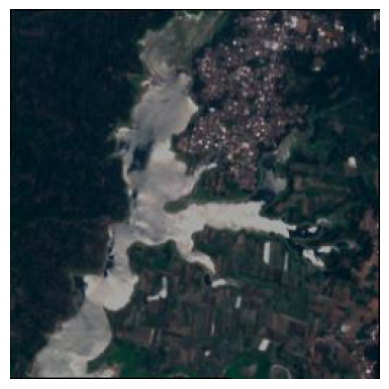

In [3]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

test_img_file = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*.jpg'
test_img_files = sorted(glob.glob(test_img_file))

test_mask_file = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*.jpg'
test_mask_files = sorted(glob.glob(test_mask_file))

# Create TensorFlow Dataset from image paths
test_dataset = tf.data.Dataset.from_tensor_slices(test_img_files)

def decode_test_images(img_filename):
    image_string = tf.io.read_file(img_filename)  # Read file
    image = tf.image.decode_jpeg(image_string, channels=3)  # Decode JPEG
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize [0,1]
    image = tf.image.resize(image, [256, 256])  # Resize
    return image

# Apply preprocessing and batch the dataset
test_dataset = test_dataset.map(decode_test_images)
test_dataset = test_dataset.batch(16)

# Display an image from the dataset
im = next(iter(test_dataset))
plt.imshow(im[1])  # Show the second image in the batch
plt.axis("off")  # Hide axes
plt.show()


In [6]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/kaggle/input/flood_detection_model/other/default/1/Food_Detection_model.h5')


In [13]:
import numpy as np

In [14]:
# Resize test images to (128, 128)
y_test = []
for i in range(len(test_mask_files)):
    mask = tf.image.decode_jpeg(tf.io.read_file(test_mask_files[i]), channels=1)
    mask = tf.image.resize(mask, [128, 128])  # Resize to match model input
    y_test.append(mask)

# Predict with resized images
output = model.predict(test_dataset.map(lambda x: tf.image.resize(x, [128, 128])), batch_size=16)

test_dataset
output = model.predict(test_dataset, batch_size = 16)
output.shape
predictions = []
for i in  range(2683):
    pred = np.array(output[i])
    pred = (pred)
    predictions.append(pred)
y_test = []
for i in range(len(test_mask_files)):
    mask = tf.image.decode_jpeg(tf.io.read_file(test_mask_files[i]), channels = 1)
    mask = tf.image.resize(mask,[256, 256])
    y_test.append(mask)
# IoU measurement
iou_scores = []
for i in range(500):
    intersection = np.logical_and(y_test[i], predictions[i])
    union = np.logical_or(y_test[i], predictions[i])
    iou_score = np.sum(intersection)/np.sum(union)
    iou_scores.append(iou_score)
print(sum(iou_scores))
iou = sum(iou_scores)/2683
print("IoU score is : ", iou)

178/178 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step
232.838791998208
IoU score is :  0.08678300111748341


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


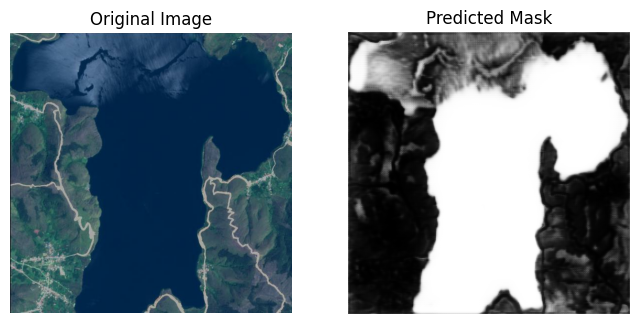

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Path to a specific image (update with actual path)
image_path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_100.jpg'

# Load the image
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)

# Resize the image to match the model's expected input size (256x256)
image = tf.image.resize(image, [256, 256])

# Normalize the image (convert pixel values to range [0,1])
image = image / 255.0

# Expand dimensions to match model input shape (batch size, height, width, channels)    
image = np.expand_dims(image, axis=0)

# Load the saved model
model = tf.keras.models.load_model('/kaggle/working/flood_detection_model.h5')

# Predict
prediction = model.predict(image)

# Display the image and prediction
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(tf.image.decode_jpeg(tf.io.read_file(image_path)))
plt.title("Original Image")
plt.axis("off")

# Predicted mask (thresholding for better visualization)
plt.subplot(1, 2, 2)
plt.imshow(prediction[0, :, :, 0], cmap="gray")  # Show predicted mask
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


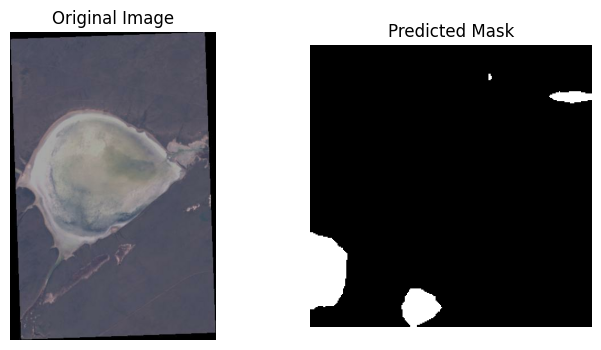

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Path to a specific image (update with actual path)
image_path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1000.jpg'

# Load the image
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)

# Resize the image to match the model's expected input size (256x256)
image = tf.image.resize(image, [256, 256])

# Normalize the image (convert pixel values to range [0,1])
image = image / 255.0

# Expand dimensions to match model input shape (batch size, height, width, channels)    
image = np.expand_dims(image, axis=0)

# Load the saved model
model = tf.keras.models.load_model('/kaggle/input/detection/other/default/1/checkmodel.h5')

# Predict
prediction = model.predict(image)

# Display the image and prediction
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(tf.image.decode_jpeg(tf.io.read_file(image_path)))
plt.title("Original Image")
plt.axis("off")

# Predicted mask (thresholding for better visualization)
plt.subplot(1, 2, 2)
plt.imshow(prediction[0, :, :, 0], cmap="gray")  # Show predicted mask
plt.title("Predicted Mask")
plt.axis("off")

plt.show()
